##Setup

In [9]:
import os
import cv2
import json
import time
from random import shuffle
import csv
import requests
from tqdm import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.layers import Dropout, Flatten, Dense, Input, MaxPool2D, GlobalAveragePooling2D, Lambda, Conv2D, concatenate, ZeroPadding2D, Layer, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
import tensorflow_addons as tfa

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!cp '/content/drive/My Drive/data/research_MILDNet_tops.zip' '/content/'

In [3]:
!cp '/content/drive/My Drive/data/research_MILDNet_tops_cropped.zip' '/content/'

In [4]:
!unzip '/content/research_MILDNet_tops_cropped.zip'

Streaming output truncated to the last 5000 lines.
  inflating: tops_cropped/77096.jpg  
  inflating: tops_cropped/359501.jpg  
  inflating: tops_cropped/52605.jpg  
  inflating: tops_cropped/382999.jpg  
  inflating: tops_cropped/274873.jpg  
  inflating: tops_cropped/289072.jpg  
  inflating: tops_cropped/203029.jpg  
  inflating: tops_cropped/390522.jpg  
  inflating: tops_cropped/348798.jpg  
  inflating: tops_cropped/7870.jpg   
  inflating: tops_cropped/238276.jpg  
  inflating: tops_cropped/46680.jpg  
  inflating: tops_cropped/189723.jpg  
  inflating: tops_cropped/387827.jpg  
  inflating: tops_cropped/18785.jpg  
  inflating: tops_cropped/420665.jpg  
  inflating: tops_cropped/200983.jpg  
  inflating: tops_cropped/47601.jpg  
  inflating: tops_cropped/246926.jpg  
  inflating: tops_cropped/377163.jpg  
  inflating: tops_cropped/266268.jpg  
  inflating: tops_cropped/292368.jpg  
  inflating: tops_cropped/399316.jpg  
  inflating: tops_cropped/304601.jpg  
  inflating: tops_c

In [6]:
!unzip '/content/research_MILDNet_tops.zip'

Streaming output truncated to the last 5000 lines.
  inflating: tops/330985.jpg         
  inflating: tops/303681.jpg         
  inflating: tops/318142.jpg         
  inflating: tops/153762.jpg         
  inflating: tops/345438.jpg         
  inflating: tops/335505.jpg         
  inflating: tops/134698.jpg         
  inflating: tops/314612.jpg         
  inflating: tops/16881.jpg          
  inflating: tops/12920.jpg          
  inflating: tops/80684.jpg          
  inflating: tops/292265.jpg         
  inflating: tops/89973.jpg          
  inflating: tops/98150.jpg          
  inflating: tops/239415.jpg         
  inflating: tops/162509.jpg         
  inflating: tops/352017.jpg         
  inflating: tops/391076.jpg         
  inflating: tops/13497.jpg          
  inflating: tops/367993.jpg         
  inflating: tops/234861.jpg         
  inflating: tops/267396.jpg         
  inflating: tops/196037.jpg         
  inflating: tops/90014.jpg          
  inflating: tops/264709.jpg         

##EDA

<h1> Visual Similarity using NN </h1>

Here we are trying to implement the research work done on the following paper:
https://arxiv.org/pdf/1901.03546v1.pdf

We'll try to implement the same using TensorFlow 2. In the above work, multi-scaled triplet based architecture was proposed, which uses Siamese network and contrastive loss to outperform the current state-of-the-art methods.

<h1> Concepts </h1>

Visual Recommendation is a crucial feature for any ecommerce platform. It gives the platform power of instantly suggesting similar looking products to what a user is browsing, thus capturing his/her immediate intent which could result in higher customer engagment (CTR) and hence the conversion.

The task of identifying similar products is not trivial as the details concerned here (pattern, structure etc.) are complexely grained in the product image pixels and these product comes in various variety even within the same class. CNNs have showed great understanding and results in this task.

The base of such a system is a CNN extracting key features from product images and returning a vector respresenting those features. When these embeddings for all the products are mapped on an n-dimensional space, it places similar products closer to non-similar items. The nearest neighbours are then the top most visual similar items.

<h1> Data Used </h1>

Triplet data consists of a query image, positive image (similar to query image) and a negative image (relatively dissimilar to query image as positive image). The query image can either be

Wild Image: where people wearing the cloth in everyday uncontrolled settings.
Catalog Image: model wearing cloth in controlled settings as shown in an ecommerce app.
While the positive and negative images can also be

In-class: same product category as query image
Out-of-class: other product category than query image

The data used in this case study is provided under the following link by the authors of the paper. They have programitically generated these triplets from 4 different data set. The link to the data is: 

https://console.cloud.google.com/storage/browser/fynd-open-source/research/MILDNet/

From the above link we were provided with 3 files:

1. train csv
2. val csv
3. test csv

All these files were downloaded, these downloaded csv contains 3 images per row, first and second image being visually similar, while first and third being dissimilar. 

<h1> Displaying top 10 triplets from each of these dataset </h1>

<h2> For Train </h2>

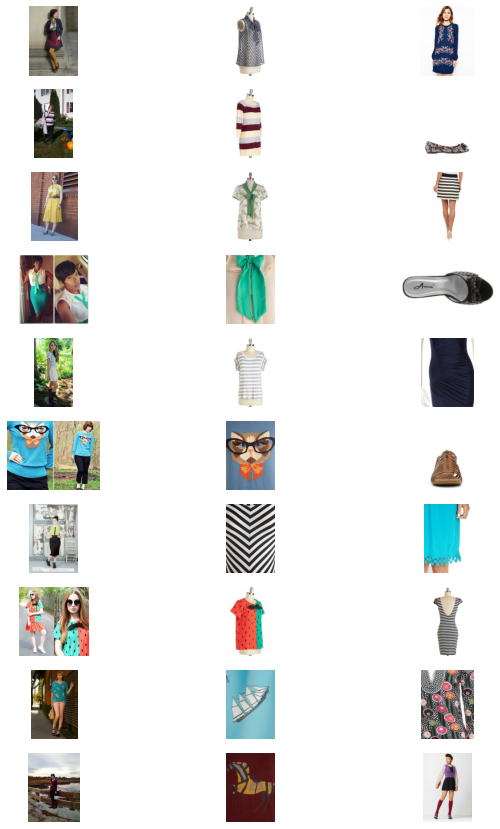

In [11]:
with open('/content/drive/My Drive/data/tops_train.csv', 'r') as file:
  train_images = file.read().split('\n')

fig=plt.figure(figsize=(10, 15))
shuffle(train_images)
subplot_index = 1

for triplet in train_images[:10]:
  triplet = triplet.split(",")
  for index in range(len(triplet)):
    img = tf.image.decode_jpeg(tf.io.read_file("/content/tops/{}".format(triplet[index])), channels=3)
    fig.add_subplot(10, 3, subplot_index)
    plt.axis('off')
    plt.imshow(img)
    subplot_index += 1

plt.axis('off')
plt.show()

<h2> For Val </h2>

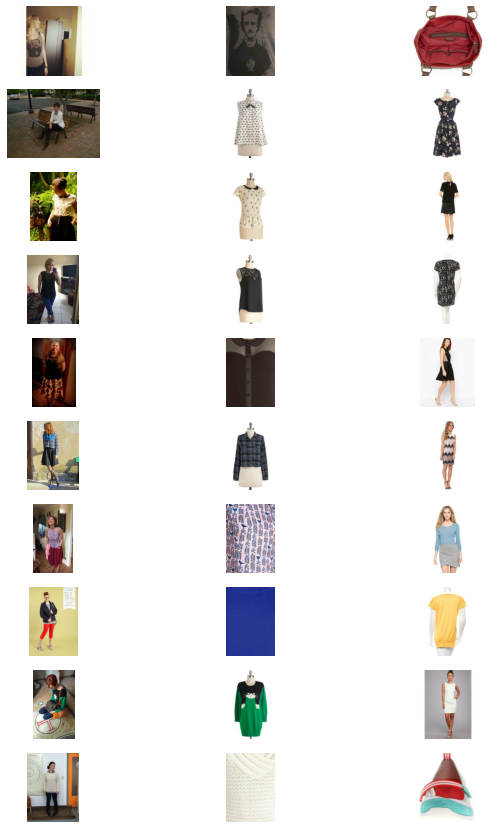

In [12]:
with open('/content/drive/My Drive/data/tops_val.csv', 'r') as file:
  train_images = file.read().split('\n')

fig=plt.figure(figsize=(10, 15))
shuffle(train_images)
subplot_index = 1

for triplet in train_images[:10]:
  triplet = triplet.split(",")
  for index in range(len(triplet)):
    img = tf.image.decode_jpeg(tf.io.read_file("/content/tops/{}".format(triplet[index])), channels=3)
    fig.add_subplot(10, 3, subplot_index)
    plt.axis('off')
    plt.imshow(img)
    subplot_index += 1

plt.axis('off')
plt.show()

<h2> For Test </h2>

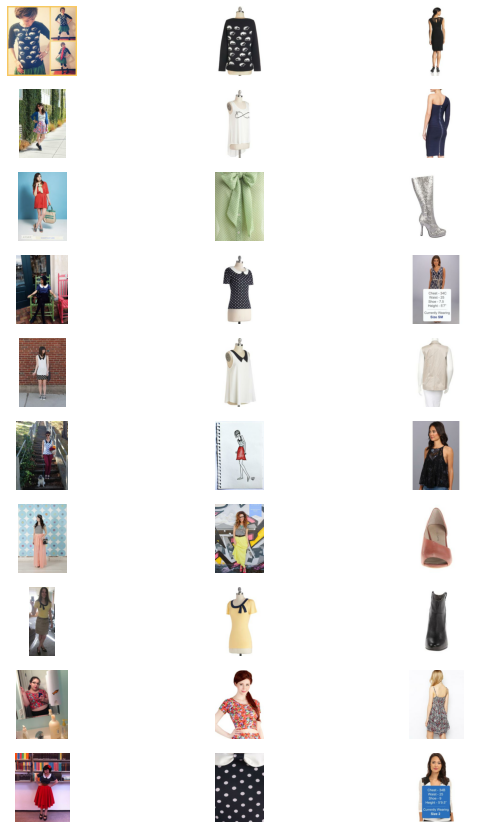

In [13]:
with open('/content/drive/My Drive/tops_test.csv', 'r') as file:
  train_images = file.read().split('\n')

fig=plt.figure(figsize=(10, 15))
shuffle(train_images)
subplot_index = 1

for triplet in train_images[:10]:
  triplet = triplet.split(",")
  for index in range(len(triplet)):
    img = tf.image.decode_jpeg(tf.io.read_file("/content/tops/{}".format(triplet[index])), channels=3)
    fig.add_subplot(10, 3, subplot_index)
    plt.axis('off')
    plt.imshow(img)
    subplot_index += 1

plt.axis('off')
plt.show()